In [ ]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview
In this notebook we perform purchase prediction analysis using logistic regression, a simple supervised learning technique to predicted binary outcomes using historical data.

## Dataset
In this tutorial, you use the sample [Google Analytics sample dataset for BigQuery](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089) to create a model that predicts whether a website visitor will make a transaction. For information on the schema of the Analytics dataset, see [BigQuery export schema](https://support.google.com/analytics/answer/3437719) in the Google Analytics Help Center.


## Objectives
Make predictions about purchase propensity for different groups of customers that can be synced into marketing platforms. We also refer to this as lead-scoring, propensity modeling, conversion prediction. 

Marketing decision makers will often say, “We are missing out on opportunities to reach customers at the moment of consideration and we're taking too long to optimize (insight --> action)”. In this tutorial, you use:

+ BigQuery ML to create a binary logistic regression model using the `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ The `ML.PREDICT` function to make predictions using the ML model
+ The BigQuery API to save these prediction scores in BQ, creating a dataset and table in your GCP project

These steps provide the basis of pushing predictive segments into Google Analytics 360 to target or supress in media campaigns.

## Costs
This tutorial uses billable components of Google Cloud Platform (GCP):

+ Cloud AI Platform
+ BigQuery ML
Learn about Cloud AI Platform pricing and BigQuery ML pricing, use the Pricing Calculator to generate a cost estimate based on your projected usage.

## Set up your GCP project
**The following steps are required, regardless of your notebook environment.**

1. Select or create a GCP project. When you first create an account, you get a $300 free credit towards your compute/storage costs.
2. Make sure that billing is enabled for your project.
3. Enable the AI Platform APIs and Compute Engine APIs.
4. Enter your project ID in the cell below. Then run the cell to make sure the Cloud SDK uses the right project for all the commands in this notebook.

**Note:** Jupyter runs lines prefixed with ! as shell commands, and it interpolates Python variables prefixed with $ into these commands.

## Create your dataset

Enter the following code to import the BigQuery Python client library and initialize a client. The BigQuery client is used to send and receive messages from the BigQuery API.

In [1]:
from google.cloud import bigquery

client = bigquery.Client(location="US")
dataset_id = "bqml_tutorial_<USERNAME>"

Next, you create a BigQuery dataset to store your ML model. Run the following to create your dataset:

In [2]:
dataset = client.create_dataset(dataset_id)

## Create your model

Next, you create a logistic regression model using the Google Analytics sample
dataset for BigQuery. The model is used to predict whether a
website visitor will make a transaction. The standard SQL query uses a
`CREATE MODEL` statement to create and train the model. Standard SQL is the
default query syntax for the BigQuery python client library.

The BigQuery python client library provides a cell magic,
`%%bigquery`, which runs a SQL query and returns the results as a Pandas
`DataFrame`.

To run the `CREATE MODEL` query to create and train your model:

In [3]:
%%bigquery training_data
CREATE OR REPLACE MODEL `bqml_tutorial_<USERNAME>.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'

Query complete after 0.01s: 100%|██████████| 3/3 [00:00<00:00, 1421.16query/s]                        


The query takes several minutes to complete. After the first iteration is
complete, your model (`sample_model`) appears in the navigation panel of the
BigQuery web UI.

## Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery web UI. This functionality
is not currently available in the BigQuery Classic web UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query:

In [4]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_tutorial_<USERNAME>.sample_model`)

Downloading: 100%|██████████| 9/9 [00:01<00:00,  6.79rows/s]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,8,0.043878,0.045445,25.6,16477
1,0,7,0.044654,0.045499,25.6,16306
2,0,6,0.047345,0.048273,12.8,15691
3,0,5,0.053888,0.053337,6.4,15297
4,0,4,0.067776,0.066406,3.2,14932
5,0,3,0.097545,0.096203,1.6,17835
6,0,2,0.169802,0.168849,0.8,14820
7,0,1,0.320692,0.320174,0.4,16304
8,0,0,0.521573,0.521380,0.2,11844


Note: Typically, it is not a best practice to use a `SELECT *` query. Because the model output is a small table, this query does not process a large amount of data. As a result, the cost is minimal.

When the query is complete, the results appear below the query. The results should look like the following:

![Training statistics table](https://i.imgur.com/DkeKSpB.png)

The `loss` column represents the loss metric calculated after the given iteration
on the training dataset. Since you performed a logistic regression, this column
is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
The `eval_loss` column is the same loss metric calculated on
the holdout dataset (data that is held back from training to validate the model).

For more details on the `ML.TRAINING_INFO` function, see the
[BigQuery ML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).

## Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function. You can also use the [`ML.ROC_CURVE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc)
function for logistic regression specific metrics.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a binary classification model that
detects transactions. The two classes are the values in the `label` column:
`0` (no transactions) and not `1` (transaction made).

To run the `ML.EVALUATE` query that evaluates the model:

In [5]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_tutorial_<USERNAME>.sample_model`, (
  SELECT
    IF(totals.transactions IS NULL, 0, 1) AS label,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(geoNetwork.country, "") AS country,
    IFNULL(totals.pageviews, 0) AS pageviews
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.21s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.468504,0.110801,0.985343,0.179217,0.046242,0.981742


When the query is complete, the results appear below the query. The
results should look like the following:

![Model evaluation results table](https://i.imgur.com/t6s7mhO.png)

Because you performed a logistic regression, the results include the following
columns:

+ [`precision`](https://developers.google.com/machine-learning/glossary/#precision)
+ [`recall`](https://developers.google.com/machine-learning/glossary/#recall)
+ [`accuracy`](https://developers.google.com/machine-learning/glossary/#accuracy)
+ [`f1_score`](https://en.wikipedia.org/wiki/F1_score)
+ [`log_loss`](https://developers.google.com/machine-learning/glossary/#Log_Loss)
+ [`roc_auc`](https://developers.google.com/machine-learning/glossary/#AUC)


## Use your model to predict outcomes

Now that you have evaluated your model, the next step is to use it to predict
outcomes. You use your model to predict the number of transactions made by
website visitors from each country. And you use it to predict purchases per user.

To run the query that uses the model to predict the number of transactions and save as a DataFrame:

In [6]:
%%bigquery predictions
SELECT
  fullvisitorid,
  country,
  os,
  is_mobile,
  pageviews,
  probs.prob as purchase_prediction_prob
FROM ML.PREDICT(MODEL `bqml_tutorial_<USERNAME>.sample_model`, (
  SELECT
    fullvisitorid,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801')), UNNEST(predicted_label_probs) as probs
ORDER BY purchase_prediction_prob DESC

Downloading: 100%|██████████| 148736/148736 [00:01<00:00, 108578.58rows/s]


Review the `purchase_prediction_prob` column to see the liklihood a site visitor is to purchase in terms of a percentage. 

In [7]:
predictions

,fullvisitorid,country,os,is_mobile,pageviews,purchase_prediction_prob
0,8388931032955052746,Taiwan,Chrome OS,False,186,9.999991e-01
1,057693500927581077,United States,Macintosh,False,175,9.999991e-01
2,6789528963693848193,United States,Chrome OS,False,169,9.999983e-01
3,332494308387844831,United States,Chrome OS,False,168,9.999981e-01
4,1280993661204347450,United States,Macintosh,False,145,9.999797e-01
...,...,...,...,...,...,...
148731,1280993661204347450,United States,Macintosh,False,145,2.028364e-05
148732,332494308387844831,United States,Chrome OS,False,168,1.854714e-06
148733,6789528963693848193,United States,Chrome OS,False,169,1.671000e-06
148734,057693500927581077,United States,Macintosh,False,175,8.874453e-07


When the query is complete, the results appear below the query. The
results should look like the following. Because model training is not
deterministic, your results may differ.

![Model predictions table](https://i.imgur.com/t6s7mhO.png)

Use the following visualization to explore the distribution of prediction scores in the data set.

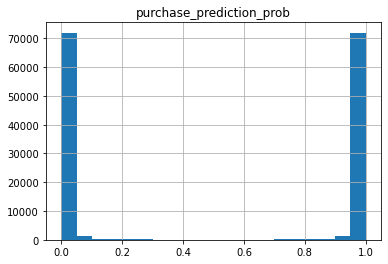

In [8]:
predictions.hist(bins=20, column="purchase_prediction_prob");

In the next example, you try to predict the number of transactions each website
visitor will make. This query is identical to the previous query except for the
`GROUP BY` clause. Here the `GROUP BY` clause &mdash; `GROUP BY fullVisitorId`
&mdash; is used to group the results by visitor ID.

To run the query that predicts purchases per user:

In [9]:
%%bigquery
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial_<USERNAME>.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY fullVisitorId
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.01rows/s]


,fullVisitorId,total_predicted_purchases
0,9417857471295131045,4
1,112288330928895942,2
2,057693500927581077,2
3,2105122376016897629,2
4,489038402765684003,2
5,5073919761051630191,2
6,2158257269735455737,2
7,7420300501523012460,2
8,8388931032955052746,2
9,2969418676126258798,2


When the query is complete, the results appear below the query. The
results should look like the following:

![Purchase predictions table](https://i.imgur.com/iCIBjDh.png)

## Optional Step: Stream the data back into BigQuery

Now that we've completed or analysis, we can save our predictions table back into BigQuery for storage for later use or joins with existing datasets. Because we saved the table as a `DataFrame` in the previous steps, we save this directly to the BigQuery and inherit the schema from the `DataFrame`.

In [10]:
#Pulled in for exceptions
from google.cloud.exceptions import NotFound

#Creating table and dataset names.
#UPDATE THESE IDs TO YOUR BIGQUERY SCHEMAS

table_id = dataset_id + ".Purchase_Prediction"

#will check to see if the dataset already exists and will not create if already exists. Will create if doesn't exist.
try:
    client.get_dataset(dataset_id)  # Make an API request.
    print("Dataset {} already exists, moving on to create Table.".format(dataset_id))
except NotFound:
    print("Dataset {} is not found. Creating now.".format(dataset_id))
    client.create_dataset("Activation")
    print("Dataset {} created.".format(dataset_id))

#Will check to see if the table already exists and will not create if already exists. Will create if doesn't exist.
try:
    client.get_table(table_id)  # Make an API request.
    print("Table {} already exists.".format(table_id))
except NotFound:
    print("Table {} is not found. Loading table.".format(table_id))
    job = client.load_table_from_dataframe(predictions, table_id)
    print(job.result().destination)


Dataset Activation is not found. Creating now.
Dataset Activation created.
Table Activation.Purchase_Prediction is not found. Loading table.
ml-teaching-project.Activation.Purchase_Prediction


To see how you might use this data set to push your predictions back into Google Analytics 360, see the [CRMint](https://google.github.io/crmint/docs/guides/) documentation.

## Cleaning up

To delete the resources created by this tutorial, execute the following code to delete the dataset and its contents:

In [ ]:
client.delete_dataset(dataset_id, delete_contents=True)